# Sparkle Movie

## Introduction

Bienvenue dans ce notebook dédié à mon projet de recommandation de films pour une plateforme de streaming vidéo, utilisant le dataset MovieLens et l'outil de traitement distribué Spark MLlib. L'objectif principal de ce projet est d'améliorer l'expérience utilisateur en proposant des recommandations personnalisées, basées à la fois sur le contenu des films et les préférences des utilisateurs.

<u>Objectifs du Projet</u> :  
1. Chargement et Exploration des Données : Nous débuterons par importer et explorer les données à l'aide de Spark, en analysant les tendances générales telles que les films les mieux notés et les genres les plus populaires.

2. Modélisation avec Spark MLlib - ALS : Nous utiliserons l'algorithme ALS (Alternating Least Squares) pour entraîner un modèle de recommandation collaborative. Nous ajusterons les hyperparamètres et évaluerons la performance du modèle à l'aide de la RMSE (Root Mean Square Error).

3. Recommandation Basée sur le Contenu : Nous créerons des profils de films basés sur leurs genres, puis implémenterons un système recommandant des films similaires à ceux aimés par un utilisateur, en utilisant TF-IDF et la similarité cosinus.

4. Recommandation Basée sur les Proximités Utilisateurs (KNN) : Nous mettrons en œuvre une approche KNN pour trouver des utilisateurs similaires et générer des recommandations basées sur leurs évaluations.

5. Évaluation des Approches de Recommandation : Nous évaluerons la précision et la couverture de nos recommandations, comparerons les résultats des différentes approches, et conclurons sur la performance globale de notre modèle.

Ce notebook sera structuré de manière à guider à travers chaque étape du processus, depuis l'exploration initiale des données jusqu'à l'évaluation finale de nos méthodes de recommandation. N'hésitez pas à suivre chaque section et à explorer les détails pour une compréhension approfondie du développement de notre outil de recommandation.

### Imports

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import stddev, avg, col, explode, split, trim, year, month
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import math
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

### 1. Préparation de l'environnement

Après avoir installé Java, j'ai exécuté la commande 'pip install pyspark. De cette manière je peux passer à l'étape suivante qui est de configurer une session Spark.

Configuration d'une session spark

Ayant des problèmes que je n'arrive pas à résoudre avec Spark, je laisse cette partie mais il ne faut <p style="background-color: red">PAS EXECUTER CE CODE</p> jusqu'à la fin du marqueur

In [ ]:
spark = SparkSession.builder \
    .appName("MovieRecommendation") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", '4g') \
    .config("spark.sql.shuffle.partitions", "200") \
    .getOrCreate()

spark.sparkContext.version

J'ai ensuite récupéré un dataset sur le site: https://grouplens.org/datasets/movielens/

### 2. Chargement et exploration des données

Je vais maintenant importer les fichiers CSV nécessaires pour réaliser ce projet, à savoir:  
- ratings.csv  
- movies.csv  

Et les mettre dans des Dataframes Spark.

In [ ]:
ratings_df = spark.read.csv("data/ml-latest-small/ratings.csv", header=True, inferSchema=True)
movies_df = spark.read.csv("data/ml-latest-small/movies.csv", header=True, inferSchema=True)

A partir d'ici le code est <p style = "color: green">FONCTIONNEL</p>

Explication: puisque j'avais des problèmes liés à l'utilisation de Spark et Java, j'ai laissé le code qui aurait du me servir en utilisant pyspark mais je fais tout le traitement par Pandas.

In [2]:
ratings_df = pd.read_csv("data/ml-latest-small/ratings.csv")
movies_df = pd.read_csv("data/ml-latest-small/movies.csv")

Puis je montre les 10 premières lignes de chaque dataset

In [3]:
ratings_df.head(10)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
5,1,70,3.0,964982400
6,1,101,5.0,964980868
7,1,110,4.0,964982176
8,1,151,5.0,964984041
9,1,157,5.0,964984100


In [4]:
movies_df.head(10)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


Je vais maintenant effectuer un nettoyage des données

On supprime les valeurs manquantes

In [5]:
ratings_df = ratings_df.dropna()
movies_df = movies_df.dropna()

Puis on fait une gestion des doublons

In [6]:
ratings_df = ratings_df.drop_duplicates()
movies_df = movies_df.drop_duplicates()

Je combine les deux dataframes en un seul

In [7]:
combined_df = pd.merge(ratings_df, movies_df[['movieId', 'title', "genres"]], on='movieId', how='left')
combined_df.head(10)

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
5,1,70,3.0,964982400,From Dusk Till Dawn (1996),Action|Comedy|Horror|Thriller
6,1,101,5.0,964980868,Bottle Rocket (1996),Adventure|Comedy|Crime|Romance
7,1,110,4.0,964982176,Braveheart (1995),Action|Drama|War
8,1,151,5.0,964984041,Rob Roy (1995),Action|Drama|Romance|War
9,1,157,5.0,964984100,Canadian Bacon (1995),Comedy|War


Je visualise et je supprime les outliers

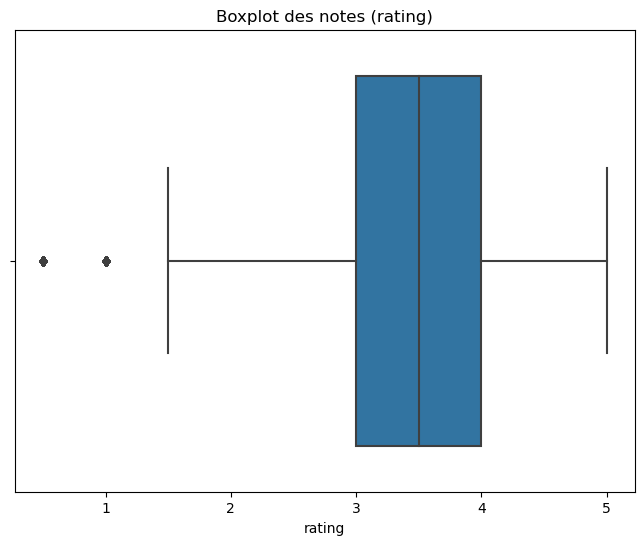

In [20]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=combined_df['rating'])
plt.title('Boxplot des notes (rating)')
plt.show()

In [21]:
# Calcul de l'écart interquartile (IQR)
Q1 = combined_df['rating'].quantile(0.25)
Q3 = combined_df['rating'].quantile(0.75)
IQR = Q3 - Q1

# Détermination des bornes pour les outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtrage des outliers
combined_df_cleaned = combined_df[(combined_df['rating'] >= lower_bound) & (combined_df['rating'] <= upper_bound)]

# Réinitialisation des index après suppression des outliers
combined_df_cleaned = combined_df_cleaned.reset_index(drop=True)

# Affichage des statistiques après nettoyage
print(f"Nombre de lignes avant nettoyage : {len(combined_df)}")
print(f"Nombre de lignes après nettoyage : {len(combined_df_cleaned)}")

Nombre de lignes avant nettoyage : 100836
Nombre de lignes après nettoyage : 96655


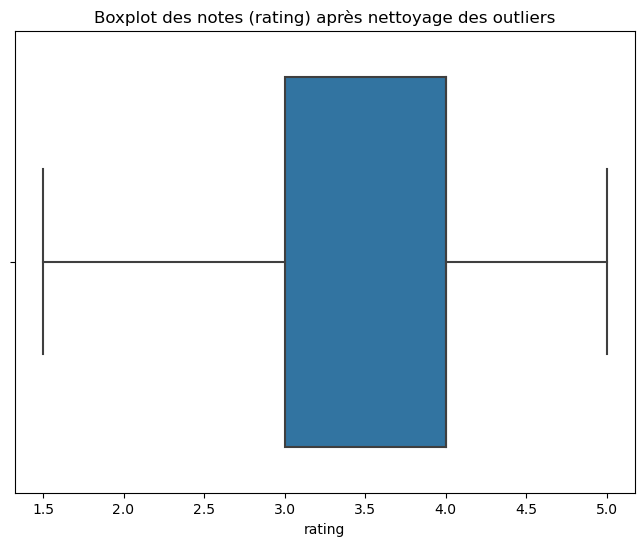

In [22]:
# Affichage du nouveau boxplot sans outliers
plt.figure(figsize=(8, 6))
sns.boxplot(x=combined_df_cleaned['rating'])
plt.title('Boxplot des notes (rating) après nettoyage des outliers')
plt.show()

Je passe maintenant à l'analyse de tendances générales

<u>Films les mieux notés en moyenne</u>

In [23]:
average_ratings = combined_df.groupby(["movieId", "title"])["rating"].mean().reset_index()

top_movies = average_ratings.sort_values(by="rating", ascending=False)

print("Films les mieux notés en moyenne :")
print(top_movies.head(10))

Films les mieux notés en moyenne :
      movieId                                      title  rating
7638    88448      Paper Birds (Pájaros de papel) (2010)     5.0
8089   100556                 Act of Killing, The (2012)     5.0
9065   143031                            Jump In! (2007)     5.0
9076   143511                               Human (2015)     5.0
9078   143559                        L.A. Slasher (2015)     5.0
4245     6201                           Lady Jane (1986)     5.0
8136   102217             Bill Hicks: Revelations (1993)     5.0
8130   102084               Justice League: Doom (2012)      5.0
4240     6192  Open Hearts (Elsker dig for evigt) (2002)     5.0
9104   145994                     Formula of Love (1984)     5.0


<u>Genres de films les plus populaires</u>

In [24]:
combined_sample = combined_df.sample(frac=0.08, random_state=42)

genre_counts_sample = combined_sample.assign(genre=combined_sample['genres'].str.split('|')) \
                                     .explode('genre') \
                                     .groupby('genre')['rating'].mean() \
                                     .reset_index(name='avg_rating') \
                                     .sort_values(by='avg_rating', ascending=False)

print("Moyenne des notes par genre de film (échantillon) :")
print(genre_counts_sample)

Moyenne des notes par genre de film (échantillon) :
                 genre  avg_rating
10           Film-Noir    3.980519
18                 War    3.834152
7          Documentary    3.755435
8                Drama    3.641109
6                Crime    3.625737
3            Animation    3.608656
14             Mystery    3.604441
13             Musical    3.582822
19             Western    3.546875
2            Adventure    3.528649
12                IMAX    3.526899
17            Thriller    3.507989
9              Fantasy    3.506529
1               Action    3.483483
15             Romance    3.477456
16              Sci-Fi    3.455564
4             Children    3.345000
5               Comedy    3.334136
11              Horror    3.212898
0   (no genres listed)    3.083333


<u>Films les moins bien notés</u>

In [25]:
average_ratings = combined_df.groupby(["movieId", "title"])["rating"].mean().reset_index()

bottom_movies = average_ratings.sort_values(by="rating", ascending=True)

print("Films les mieux notés en moyenne :")
print(bottom_movies.head(10))

Films les mieux notés en moyenne :
      movieId                                  title  rating
5541    26696                       Lionheart (1990)     0.5
2685     3604                           Gypsy (1962)     0.5
4872     7312                Follow Me, Boys! (1966)     0.5
9099   145724                  Idaho Transfer (1973)     0.5
7280    76030                         Case 39 (2009)     0.5
9103   145951     Bloodsport: The Dark Kumite (1999)     0.5
7536    85334           Hard Ticket to Hawaii (1987)     0.5
8764   129250                      Superfast! (2015)     0.5
8125   102025  Yongary: Monster from the Deep (1967)     0.5
9572   175475                 The Emoji Movie (2017)     0.5


<u>Distribution des genres de films</u>

In [26]:
genre_counts = movies_df.assign(genres=movies_df['genres'].str.split('|')) \
                       .explode('genres') \
                       .groupby('genres').size() \
                       .reset_index(name='count') \
                       .sort_values(by='count', ascending=False)

print("Distribution des genres de films :")
print(genre_counts)

Distribution des genres de films :
                genres  count
8                Drama   4361
5               Comedy   3756
17            Thriller   1894
1               Action   1828
15             Romance   1596
2            Adventure   1263
6                Crime   1199
16              Sci-Fi    980
11              Horror    978
9              Fantasy    779
4             Children    664
3            Animation    611
14             Mystery    573
7          Documentary    440
18                 War    382
13             Musical    334
19             Western    167
12                IMAX    158
10           Film-Noir     87
0   (no genres listed)     34


Maintenant que mon analyse de tendances générales est faite, je vais faire les visualisations.  

Dans un premier temps, je vais faire des visualisations en utilisant des librairies Python puis, j'utiliserai l'outil Tableau Desktop.

<u>Visuel pour les films les mieux notés</u>

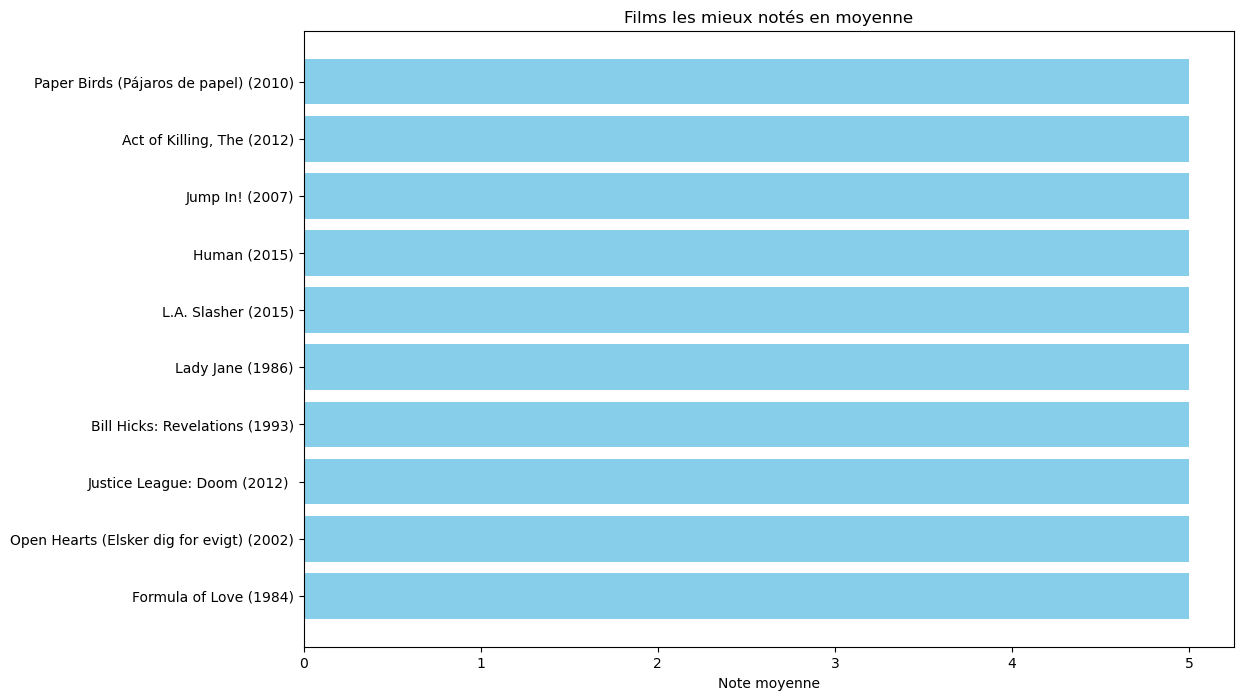

In [27]:
top_movies = average_ratings.sort_values(by="rating", ascending=False).head(10)

plt.figure(figsize=(12, 8))
plt.barh(top_movies["title"], top_movies["rating"], color='skyblue')
plt.xlabel('Note moyenne')
plt.title('Films les mieux notés en moyenne')
plt.gca().invert_yaxis()
plt.show()

<u>Visuel pour les films les moins bien notés</u>

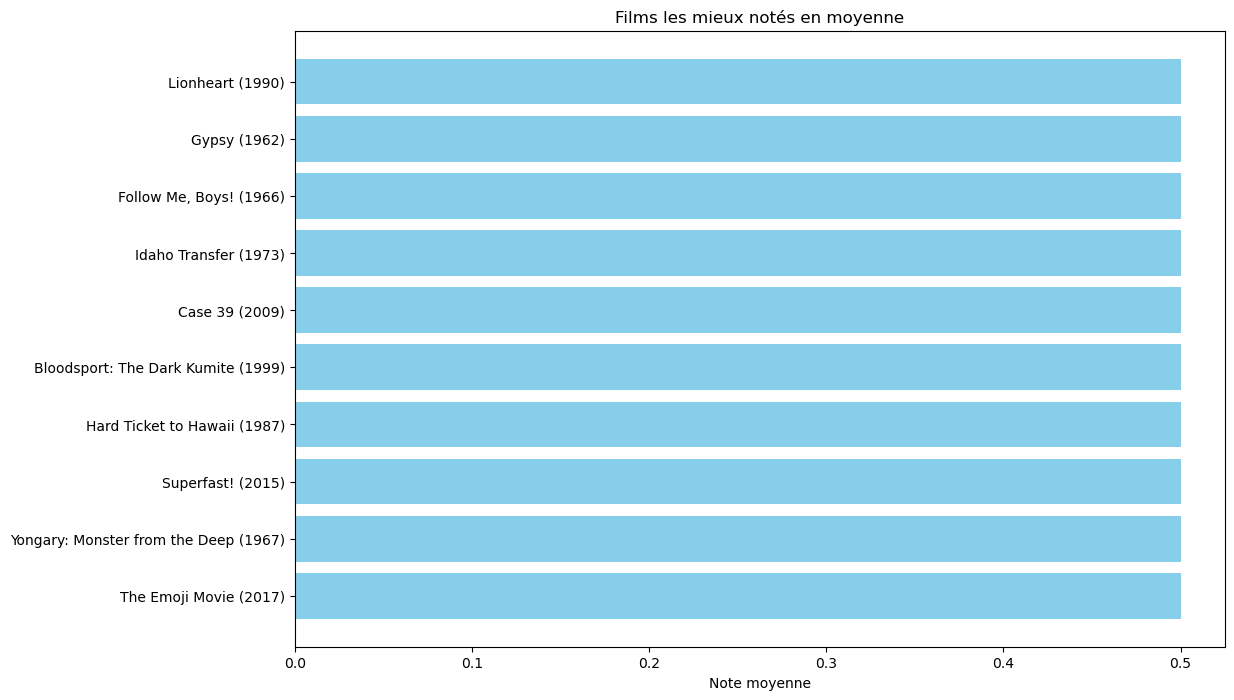

In [28]:
bottom_movies = average_ratings.sort_values(by="rating", ascending=True).head(10)

# Créer le graphique des films les moins bien notés en moyenne
plt.figure(figsize=(12, 8))
plt.barh(bottom_movies["title"], bottom_movies["rating"], color='skyblue')
plt.xlabel('Note moyenne')
plt.title('Films les mieux notés en moyenne')
plt.gca().invert_yaxis()
plt.show()

<u>Visuel pour les genres de films les plus populaires</u>

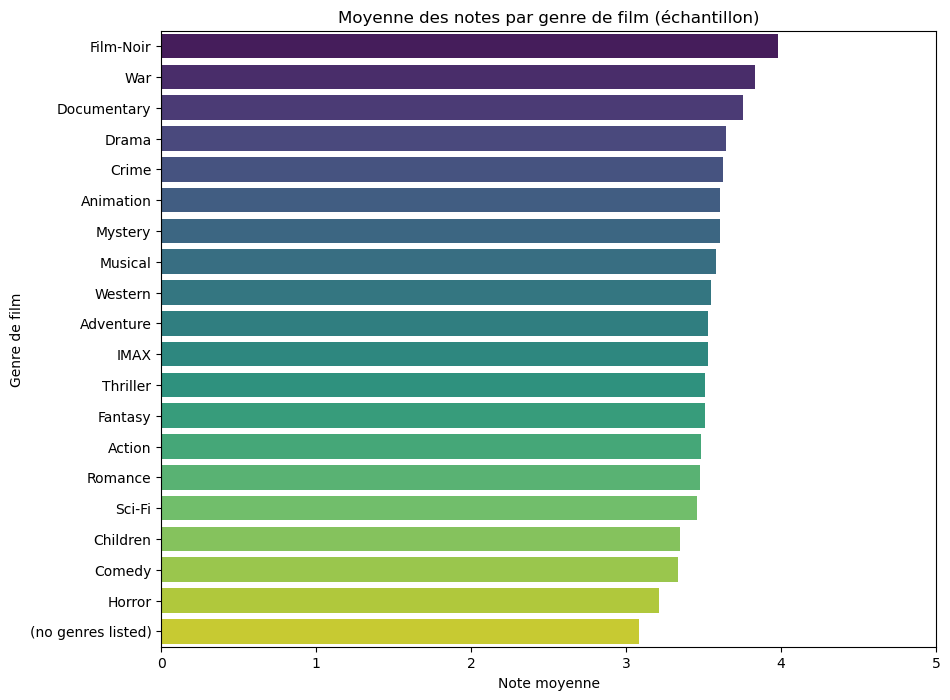

In [29]:
plt.figure(figsize=(10, 8))
sns.barplot(x='avg_rating', y='genre', data=genre_counts_sample, palette='viridis')
plt.xlabel('Note moyenne')
plt.ylabel('Genre de film')
plt.title('Moyenne des notes par genre de film (échantillon)')
plt.xlim(0, 5) 
plt.show()

<u>Visuel pour la distribution de genres de films</u>

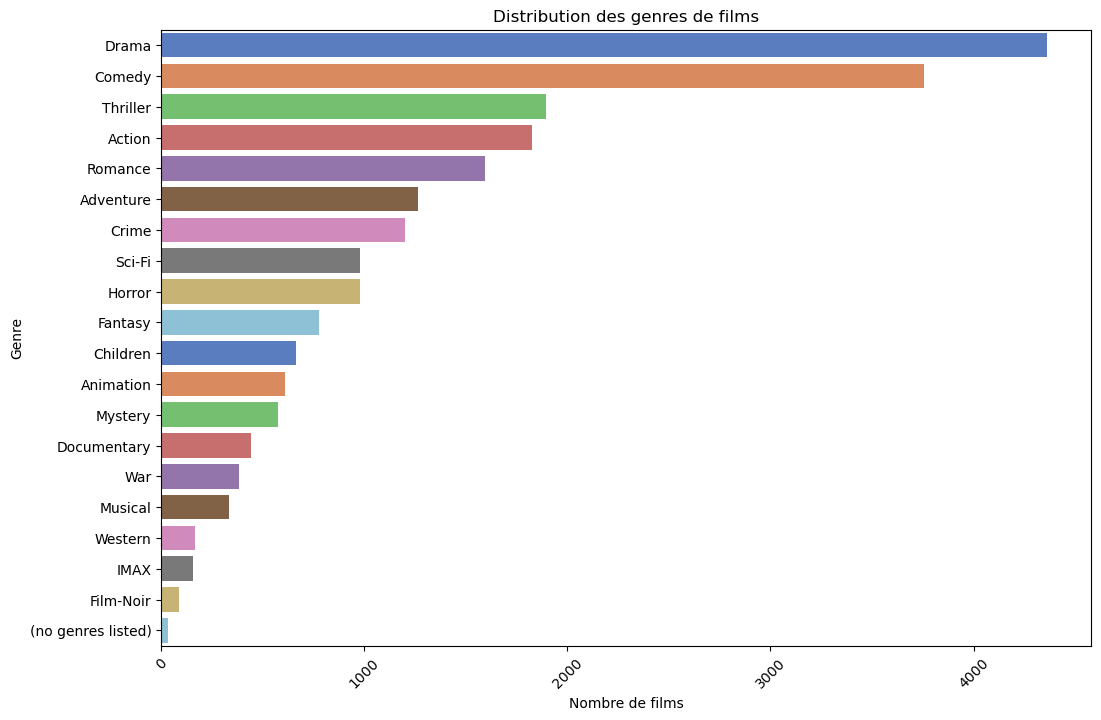

In [30]:
plt.figure(figsize=(12, 8))
sns.barplot(x='count', y='genres', data=genre_counts, palette='muted')
plt.xlabel('Nombre de films')
plt.ylabel('Genre')
plt.title('Distribution des genres de films')
plt.xticks(rotation=45)
plt.show()

### 3. Modélisation avec Spark MLlib : ALS

In [31]:
num_factors = 3

# Réduire le nombre d'epochs et ajuster les hyperparamètres
num_epochs = 10
learning_rate = 0.005 
reg_param = 0.05    

# Prendre un échantillon de combined_df
combined_sample = combined_df.sample(frac=0.08, random_state=42) 

# Réinitialisation des indices userId et movieId pour commencer à zéro sur l'échantillon
combined_sample['userId'] = combined_sample['userId'].astype('category').cat.codes
combined_sample['movieId'] = combined_sample['movieId'].astype('category').cat.codes

# Nombre d'utilisateurs et d'articles uniques sur l'échantillon
num_users_sample = combined_sample['userId'].nunique()
num_items_sample = combined_sample['movieId'].nunique()

# Initialisation aléatoire des matrices latentes P (utilisateurs) et Q (articles) sur l'échantillon
P_sample = np.random.rand(num_users_sample, num_factors)
Q_sample = np.random.rand(num_items_sample, num_factors)

# Fonction d'entraînement ALS adaptée à l'échantillon
def train_als_sample(combined_sample, P_sample, Q_sample, num_factors, num_epochs, learning_rate, reg_param):
    for epoch in range(num_epochs):
        for index, row in combined_sample.iterrows():
            user_id = int(row['userId'])
            item_id = int(row['movieId'])
            rating = row['rating']

            # Calcul de l'erreur
            error = rating - np.dot(P_sample[user_id], Q_sample[item_id])

            # Mise à jour des matrices latentes P et Q
            P_sample[user_id, :] += learning_rate * (error * Q_sample[item_id, :] - reg_param * P_sample[user_id, :])
            Q_sample[item_id, :] += learning_rate * (error * P_sample[user_id, :] - reg_param * Q_sample[item_id, :])

# Entraînement du modèle ALS avec l'échantillon
train_als_sample(combined_sample, P_sample, Q_sample, num_factors, num_epochs, learning_rate, reg_param)

# Prédiction des évaluations pour tous les utilisateurs et articles sur l'échantillon
predicted_ratings_sample = np.dot(P_sample, Q_sample.T)

# Affichage des prédictions (exemple avec les premiers utilisateurs et articles sur l'échantillon)
predicted_ratings_df_sample = pd.DataFrame(predicted_ratings_sample, index=np.arange(num_users_sample), columns=np.arange(num_items_sample))
print("Prédictions des évaluations sur l'échantillon :")
print(predicted_ratings_df_sample)


Prédictions des évaluations sur l'échantillon :
         0         1         2         3         4         5         6     \
0    5.562057  3.570029  3.951797  2.680277  4.972252  4.360924  4.748810   
1    2.563219  1.760870  1.905743  1.382847  2.291725  2.092046  2.132701   
2    1.267398  0.825571  0.896178  0.600868  1.116190  0.980983  1.055330   
3    4.036570  2.702861  2.940069  2.069287  3.596288  3.228721  3.376817   
4    5.287845  3.455342  3.830740  2.682125  4.764360  4.236532  4.531214   
..        ...       ...       ...       ...       ...       ...       ...   
589  5.461584  3.613605  4.047988  2.940354  4.996234  4.502805  4.752001   
590  4.576934  3.000037  3.372280  2.429239  4.187696  3.754369  3.996910   
591  4.884328  3.107156  3.492961  2.401061  4.421535  3.879616  4.252226   
592  2.189714  1.531051  1.752192  1.416922  2.091920  1.975993  1.975629   
593  6.026628  3.917475  4.378711  3.084163  5.465658  4.858953  5.218599   

         7         8       

### 4. Recommandation basée sur le contenu

In [ ]:
combined_sample = combined_df_cleaned.sample(frac=0.2, random_state=42)  
tfidf = TfidfVectorizer(stop_words='english')
genres_matrix = tfidf.fit_transform(combined_sample['genres'])
cosine_sim = cosine_similarity(genres_matrix, genres_matrix)

In [ ]:
# Fonction pour recommander des films similaires à un film donné
def recommend_similar_movies(movie_title, cosine_sim=cosine_sim, combined_df_cleaned=combined_df_cleaned):
    idx = combined_df_cleaned.index[combined_df_cleaned['title'] == movie_title].tolist()
    if not idx:
        print(f"Le film '{movie_title}' n'est pas présent dans la base de données.")
        return []

    idx = idx[0]

    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]

    movie_indices = [i[0] for i in sim_scores]

    recommended_movies = combined_df_cleaned.iloc[movie_indices]['title'].tolist()
    
    return recommended_movies

movie_title = "Toy Story (1995)"
recommended_movies = recommend_similar_movies(movie_title)

print(f"Films recommandés pour '{movie_title}':")
for movie in recommended_movies:
    print(movie)


Films recommandés pour 'Toy Story (1995)':
Welcome to Woop-Woop (1997)
Teenage Mutant Ninja Turtles II: The Secret of the Ooze (1991)
Bullets Over Broadway (1994)
Austin Powers: The Spy Who Shagged Me (1999)
Ace Ventura: Pet Detective (1994)
Island, The (2005)
Emma (1996)
What Lies Beneath (2000)
Speed (1994)
Enter the Dragon (1973)


### 5. Recommandation Basée sur les Proximités Utilisateurs (KNN)

In [ ]:
ratings_matrix = combined_df_cleaned.pivot(index='userId', columns='movieId', values='rating').fillna(0)
model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
model_knn.fit(ratings_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [ ]:
# 4. Fonction pour trouver les voisins les plus proches d'un utilisateur donné
def find_similar_users(user_id, ratings_matrix, model_knn, k=5):
    distances, indices = model_knn.kneighbors(ratings_matrix.iloc[user_id].values.reshape(1, -1), n_neighbors=k+1)
    similar_users = []
    for i in range(1, len(distances.flatten())):
        similar_users.append(indices.flatten()[i])
    return similar_users

user_id = 11
similar_users = find_similar_users(user_id, ratings_matrix, model_knn)

In [ ]:
def generate_user_based_recommendations(user_id, ratings_matrix, similar_users, n=10):
    user_ratings = ratings_matrix.iloc[user_id]
    recommended_movies = []
    seen_movies = set(user_ratings[user_ratings > 0].index)
    for neighbor_id in similar_users:
        neighbor_ratings = ratings_matrix.iloc[neighbor_id]
        movies_to_recommend = neighbor_ratings[neighbor_ratings > 3].index
        movies_to_recommend = [movie for movie in movies_to_recommend if movie not in seen_movies]  
        recommended_movies.extend(movies_to_recommend)
        if len(recommended_movies) >= n:
            break
    return recommended_movies[:n]

recommendations = generate_user_based_recommendations(user_id, ratings_matrix, similar_users)
print(f"Recommandations pour l'utilisateur {user_id}:")
for movie_id in recommendations:
    movie_title = combined_df_cleaned.loc[combined_df_cleaned['movieId'] == movie_id, 'title'].iloc[0]
    print(movie_title)

Recommandations pour l'utilisateur 11:
Toy Story (1995)
Jumanji (1995)
Grumpier Old Men (1995)
Waiting to Exhale (1995)
Father of the Bride Part II (1995)
Heat (1995)
Sabrina (1995)
Tom and Huck (1995)
Sudden Death (1995)
GoldenEye (1995)


### 6. Evaluation des approches de recommandation

In [ ]:
def calculate_precision(user_id, recommended_movies):
    liked_movies = ratings_matrix.loc[user_id][ratings_matrix.loc[user_id] > 0].index
    relevant_recommendations = [movie for movie in recommended_movies if movie in liked_movies]
    precision = len(relevant_recommendations) / len(recommended_movies) if len(recommended_movies) > 0 else 0
    
    return precision


In [ ]:
def calculate_coverage(user_id, recommended_movies, combined_df_cleaned):
    total_movies = combined_df_cleaned['movieId'].nunique()
    coverage = len(recommended_movies) / total_movies if total_movies > 0 else 0
    return coverage



In [65]:
# Fonction pour évaluer la précision et la couverture des recommandations
def evaluate_recommendation_approaches(user_ids, ratings_matrix, model_knn, cosine_sim, tfidf, combined_df_cleaned):
    results = {}
    for user_id in user_ids:
        try:
            # Méthode 1: Recommandation basée sur le contenu (TF-IDF, similarité cosinus)
            movie_title = combined_df_cleaned.loc[combined_df_cleaned['userId'] == user_id, 'title'].iloc[0]
            recommended_movies_content_based = recommend_similar_movies(movie_title, cosine_sim, combined_df_cleaned)
            
            # Méthode 2: Recommandation basée sur les voisins proches (KNN)
            similar_users = find_similar_users(user_id, ratings_matrix, model_knn)
            recommendations_knn = generate_user_based_recommendations(user_id, ratings_matrix, similar_users)
            
            # Calcul de la précision et de la couverture pour chaque méthode
            precision_content_based = calculate_precision(user_id, recommended_movies_content_based)
            precision_knn = calculate_precision(user_id, recommendations_knn)
            
            coverage_content_based = calculate_coverage(user_id, recommended_movies_content_based, combined_df_cleaned)
            coverage_knn = calculate_coverage(user_id, recommendations_knn, combined_df_cleaned)
            
            # Enregistrer les résultats
            results[user_id] = {
                'precision_content_based': precision_content_based,
                'precision_knn': precision_knn,
                'coverage_content_based': coverage_content_based,
                'coverage_knn': coverage_knn
            }
            
            # Afficher les résultats pour chaque utilisateur
            print(f"Résultats pour l'utilisateur {user_id}:")
            print(f"   Précision (Contenu basé sur TF-IDF): {precision_content_based}")
            print(f"   Précision (KNN): {precision_knn}")
            print(f"   Couverture (Contenu basé sur TF-IDF): {coverage_content_based}")
            print(f"   Couverture (KNN): {coverage_knn}\n")
        
        except IndexError:
            print(f"Erreur : L'index est hors limites pour l'utilisateur {user_id}.")
            continue
    
    return results

# Exemple d'utilisation avec tous les utilisateurs du DataFrame
user_ids = combined_df_cleaned['userId'].unique().tolist()
evaluation_results = evaluate_recommendation_approaches(user_ids, ratings_matrix, model_knn, cosine_sim, tfidf, combined_df_cleaned)


Résultats pour l'utilisateur 1:
   Précision (Contenu basé sur TF-IDF): 0.0
   Précision (KNN): 0.3
   Couverture (Contenu basé sur TF-IDF): 0.0010551862403714255
   Couverture (KNN): 0.0010551862403714255

Résultats pour l'utilisateur 2:
   Précision (Contenu basé sur TF-IDF): 0.0
   Précision (KNN): 0.0
   Couverture (Contenu basé sur TF-IDF): 0.0010551862403714255
   Couverture (KNN): 0.0010551862403714255

Résultats pour l'utilisateur 3:
   Précision (Contenu basé sur TF-IDF): 0.0
   Précision (KNN): 0.0
   Couverture (Contenu basé sur TF-IDF): 0.0010551862403714255
   Couverture (KNN): 0.0010551862403714255

Résultats pour l'utilisateur 4:
   Précision (Contenu basé sur TF-IDF): 0.0
   Précision (KNN): 0.0
   Couverture (Contenu basé sur TF-IDF): 0.0010551862403714255
   Couverture (KNN): 0.0010551862403714255

Résultats pour l'utilisateur 5:
   Précision (Contenu basé sur TF-IDF): 0.0
   Précision (KNN): 0.1
   Couverture (Contenu basé sur TF-IDF): 0.0010551862403714255
   Couver

### 3. Modélisation avec Spark MLlib : ALS SPARK



In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Création de la session Spark
spark = SparkSession.builder \
    .appName("Recommendation System with ALS") \
    .getOrCreate()

als = ALS(userCol="userId", itemCol="movieId", ratingCol="rating", coldStartStrategy="drop")

# Construction du grid des paramètres
paramGrid = ParamGridBuilder() \
    .addGrid(als.rank, [10, 20, 30]) \
    .addGrid(als.maxIter, [10, 20, 30]) \
    .addGrid(als.regParam, [0.1, 0.01, 0.001]) \
    .build()

# Configuration du validateur croisé
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
crossval = CrossValidator(estimator=als,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)


# Séparation des données en jeu d'entraînement et de test
(training, test) = movies_df.randomSplit([0.8, 0.2], seed=123)

# Entraînement du modèle
model = crossval.fit(training)

# Prédiction sur le jeu de test
predictions = model.transform(test)

# Calcul de la RMSE sur le jeu de test
rmse = evaluator.evaluate(predictions)
print(f"RMSE = {rmse}")

# Meilleur modèle
best_model = model.bestModel
